In [ ]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD,Adam
import tf2onnx
import numpy as np
import math

In [1]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255 
x_test = x_test.astype('float32') / 255
n_class = 10
y_train = to_categorical(y_train, n_class)
y_test = to_categorical(y_test, n_class)
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


## Define the model architechture

In [3]:
def AlexNet1():
    model = Sequential()
    # Layer 1
    model.add(Conv2D(96, kernel_size=(3,3), strides = 4, padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2,2),  strides = 2, padding='same'))
    # Layer 2
    model.add(Conv2D(256, kernel_size=(5,5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),  strides = 2))
    # Layer 3
    model.add(Conv2D(384, kernel_size=(3,3), padding='same', activation='relu'))
    # Layer 4
    model.add(Conv2D(384, kernel_size=(3,3), padding='same', activation='relu'))
    # Layer 5
    model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides = 2))
    # Dense 1
    model.add(Flatten())
    model.add(Dense(4096))
    model.add(Dropout(0.5))
    # Dense 2
    model.add(Dense(4096))
    model.add(Dropout(0.5))
    # Output
    model.add(Dense(10,activation='softmax'))
    return model
model = AlexNet1()

### Lets compile the model, we will use SGD optimizer, lr=0.001, loss=categorical_crossentropy

In [ ]:
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [4]:
# verbose = progress bar setting
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=50,
                    verbose=1,
                    validation_data=(x_train, y_train))

Epoch 1/50
391/391 [==============================] - 12s 21ms/step - loss: 2.3021 - accuracy: 0.1029 - val_loss: 2.3011 - val_accuracy: 0.1177
Epoch 2/50
391/391 [==============================] - 6s 16ms/step - loss: 2.3007 - accuracy: 0.1239 - val_loss: 2.2987 - val_accuracy: 0.1621
Epoch 3/50
391/391 [==============================] - 6s 16ms/step - loss: 2.2977 - accuracy: 0.1390 - val_loss: 2.2915 - val_accuracy: 0.2081
Epoch 4/50
391/391 [==============================] - 6s 16ms/step - loss: 2.2873 - accuracy: 0.1510 - val_loss: 2.2580 - val_accuracy: 0.1540
Epoch 5/50
391/391 [==============================] - 6s 16ms/step - loss: 2.2326 - accuracy: 0.1707 - val_loss: 2.1185 - val_accuracy: 0.1936
Epoch 6/50
391/391 [==============================] - 6s 16ms/step - loss: 2.0980 - accuracy: 0.1974 - val_loss: 2.0529 - val_accuracy: 0.2282
Epoch 7/50
391/391 [==============================] - 6s 16ms/step - loss: 2.0434 - accuracy: 0.2221 - val_loss: 2.0217 - val_accuracy: 0.239

## We can save this model and the training history for future use!

 #### Lets visualize what happened first

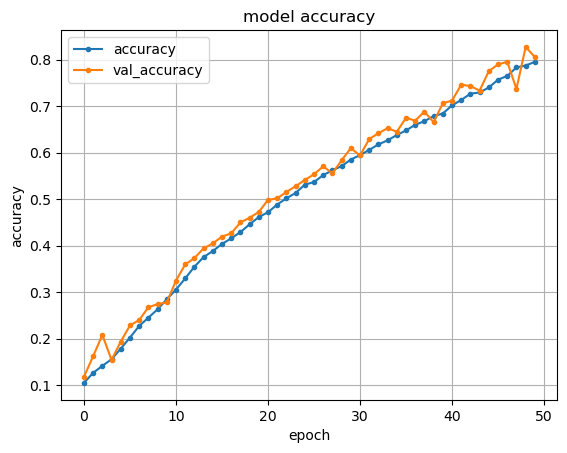

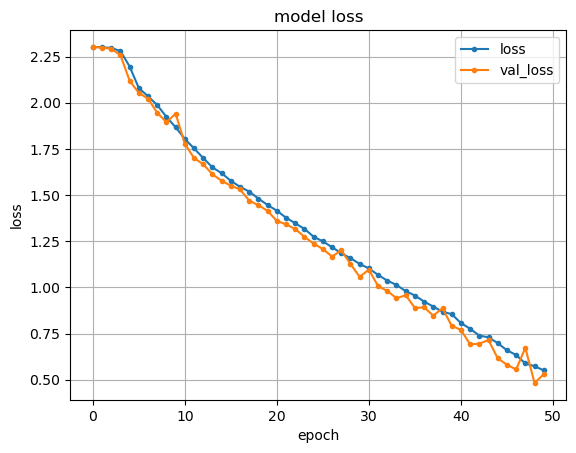

In [8]:
from matplotlib import pyplot as plt

## Model accuracy
plt.plot(history.history['accuracy'], marker='.', label='accuracy')
plt.plot(history.history['val_accuracy'], marker='.', label='val_accuracy')
plt.title('model accuracy')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

# Model loss
plt.plot(history.history['loss'], marker='.', label='loss')
plt.plot(history.history['val_loss'], marker='.', label='val_loss')
plt.title('model loss')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

In [5]:
import time
import os
import copy
import csv
import pandas as pd
from datetime import datetime

In [6]:
def export_history_csv(history_, model_name): 
    since = time.time() 
    date = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')
    data_file = open('./data/23-08-2021/tf_exp_train_{}_{}.csv'.format(model_name, date), mode='w+', newline='', encoding='utf-8')
    data_writer = csv.writer(data_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    data_writer.writerow(['Model','type', 'Dataset', 'Epoch', 'criterion', 'optimizer', 'scheduler','Train_loss', 'Train_acc', "val_loss", "Val_acc", 'time','Elapse_time','date'])
    for epoch_ in history_.epoch:
        data_writer.writerow([history_.model,'tensorflow', 'hymenoptera', epoch_, '', 
                          history_.model.optimizer, '',history_.history['loss'][epoch_], history_.history['accuracy'][epoch_], 
                          history_.history['val_loss'][epoch_], history_.history['val_accuracy'][epoch_], '','',date])
    data_file.close()

In [9]:
model_name = 'Alexnet-cifar10'
date = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')
model.save("./data/23-08-2021/tf_{}_{}-v2.h5".format(model_name, date))
# export history in csv
export_history_csv(history, model_name)

### We can create a data generator to use during model export

In [14]:
import tensorflow as tf
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    horizontal_flip=True,
    validation_split=0.2)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_test)

# Lets convert to onnx 

In [20]:
# Just to test reloading the saved model
since_0 = time.time()
path = './data/23-08-2021/'
model_name = 'tf_Alexnet-cifar10_2021-09-28-14:00:08-v2'
tf.keras.models.load_model(path+ model_name+'.h5')
t_elapsed_0 = time.time() - since_0
size0 = os.path.getsize(path+ model_name+'.h5')
size0

172794408

In [21]:
import tf2onnx
import onnx
import onnxruntime
import time
import pandas as pd 

In [22]:
def to_onnx(i, x, abs_errors,rel_errors, t0_list, t1_list, t2_list, t3_list, s_list):
    # Input to the model
    print("converting for batch: ", i)
    
    since_1 = time.time()
    #model = torch.load(path+model_name+'.pth')
    with tf.device('/cpu:0'): 
        k_predict = model.predict(x)
    t_elapsed_1 = time.time() - since_1
    # Export the model
    since_1 = time.time()
    model_proto, external_tensor_storage = tf2onnx.convert.from_keras(model,
                input_signature=None, opset=11, custom_ops=None,
                custom_op_handlers=None, custom_rewriter=None,
                inputs_as_nchw=None, extra_opset=None, shape_override=None,
                 target=None, large_model=False, output_path='./data/ONNX/keras/keras-{}.onnx'.format(model_name))
    t_elapsed_2 = time.time() - since_1
    
    
    onnx_model = onnx.load("./data/ONNX/keras/keras-{}.onnx".format(model_name))
    onnx.checker.check_model(onnx_model)
    size2 = os.path.getsize("./data/ONNX/keras/keras-{}.onnx".format(model_name))
    s_list.append(size2)
    #def to_numpy(tensor):
    #    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()
    ort_session = onnxruntime.InferenceSession("./data/ONNX/keras/keras-{}.onnx".format(model_name))
    since_1 = time.time()
    ort_inputs = {ort_session.get_inputs()[0].name: x}
    ort_outs = ort_session.run(None, ort_inputs)
    t_elapsed_3 = time.time() - since_1
    # compare ONNX Runtime and PyTorch results
    print("\n*********\n\n")
    #time_diff = t_elapsed_0+t_elapsed_1, t_elapsed_2, t_elapsed_3
    t0_list.append(t_elapsed_0)
    t1_list.append(t_elapsed_1)
    t2_list.append(t_elapsed_2)
    t3_list.append(t_elapsed_3)
    
    abs_err = np.absolute(k_predict-ort_outs[0])
    rel_err = np.absolute(k_predict-ort_outs[0])/ np.absolute(ort_outs[0])
    abs_errors.append(abs_err)
    rel_errors.append(rel_err)
    
    return (abs_err, rel_err)

In [23]:
def _lets_convert2(data, x, y, batch_size): # for cifar10 etc
    since = time.time()
    list_converted = []
    t0_list = []
    t1_list = []
    t2_list = []
    t3_list = []
    s_list = []
    abs_errors = []
    rel_errors = []
    
    batches = 0
    for x_batch, y_batch in data.flow(x, y, batch_size=batch_size):
        list_converted.append(to_onnx(batches, x_batch, abs_errors,rel_errors, t0_list, t1_list, t2_list, t3_list, s_list))
        batches += 1
        if batches >= len(x_train) / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
        if batches == 15:
            break
    time_elapsed = time.time() - since
    print('Conversion complete in {:.0f}m {:.0f}s,  Loading Pytorch: {}, Pytorch time: {:.4f}, conversion time: {:.4f}, onnx runtime: {:.4f}, onnx filesize: {}'.format(
        time_elapsed // 60, time_elapsed % 60, np.mean(np.array(t0_list)), np.mean(np.array(t1_list)), np.mean(np.array(t2_list)), np.mean(np.array(t3_list)), np.mean(np.array(s_list))) )
    
    #return list_converted
    return list_converted, abs_errors, rel_errors, 'Conversion complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60), np.mean(np.array(t0_list)), np.mean(np.array(t1_list)), np.mean(np.array(t2_list)), np.mean(np.array(t3_list)), np.mean(np.array(s_list))

In [24]:
for batch_size in [1, 5,10,20,30,40,50,60,70,80,90,100, 128,150,200, 250,300,350, 400, 450, 500]:
    print("################ Batch size: ", batch_size)
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)
    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(x_test)

    list_converted, abs_errors, rel_errors, total_time, t0, t1, t2, t3, file_size = _lets_convert2(datagen, x_test, y_test, batch_size)
    for i in range(len(abs_errors)):
        if i == 0:
            abs_array = abs_errors[i]
            rel_array = rel_errors[i]
        else:
            np.append(abs_array, abs_errors[i])
            np.append(rel_array, rel_errors[i])
            
    abs_list = []
    rel_list = []
    model_list = []
    batch_list = []
    summary_list = ['Modelsize:{}, Conversion: {}, Loading: {}, t1: {}, conversion time: {}, onnx runtime: {}, onnx filesize: {}'.format(size0, total_time, t0, t1, t2, t3, file_size)]
    for i in range(len(abs_array)):
        abs_list.append(abs_array[i][0])
        rel = rel_array[i][0]
        if rel == np.inf or rel == -np.inf:
            rel = 0.0
        rel_list.append(rel)
        batch_list.append(batch_size)
        model_list.append(model_name)
        if i >= len(summary_list):
            summary_list.append('')
    print(len(summary_list), len(rel_list))
    data = pd.DataFrame({'model':model_list,'batch_size': batch_list, 'abs_errors':abs_list, 'rel_errors':rel_list, 'summary': summary_list})
    data.to_csv('./data/errors/keras2/tf_errors_{}_{}.csv'.format(model_name, batch_size))

################ Batch size:  1
converting for batch:  0

*********


converting for batch:  1

*********


converting for batch:  2

*********


converting for batch:  3

*********


converting for batch:  4

*********


converting for batch:  5

*********


converting for batch:  6

*********


converting for batch:  7

*********


converting for batch:  8

*********


converting for batch:  9

*********


converting for batch:  10

*********


converting for batch:  11

*********


converting for batch:  12

*********


converting for batch:  13

*********


converting for batch:  14

*********


Conversion complete in 6m 16s,  Loading Pytorch: 0.4201643466949463, Pytorch time: 0.1316, conversion time: 24.3963, onnx runtime: 0.0042, onnx filesize: 86364269.33333333
1 1
################ Batch size:  5
converting for batch:  0

*********


converting for batch:  1

*********


converting for batch:  2

*********


converting for batch:  3

*********


converting for batch:  4

*******

<ipython-input-22-b876331a47cc>:40: RuntimeWarning: invalid value encountered in true_divide
  rel_err = np.absolute(k_predict-ort_outs[0])/ np.absolute(ort_outs[0])



*********


converting for batch:  11

*********


converting for batch:  12

*********


converting for batch:  13

*********


converting for batch:  14

*********


Conversion complete in 6m 50s,  Loading Pytorch: 0.4201643466949463, Pytorch time: 0.1375, conversion time: 26.5995, onnx runtime: 0.0073, onnx filesize: 86364273.06666666
5 5
################ Batch size:  10
converting for batch:  0

*********


converting for batch:  1

*********


converting for batch:  2

*********


converting for batch:  3

*********


converting for batch:  4

*********


converting for batch:  5

*********


converting for batch:  6

*********


converting for batch:  7

*********


converting for batch:  8

*********


converting for batch:  9

*********


converting for batch:  10

*********


converting for batch:  11

*********


converting for batch:  12

*********


converting for batch:  13

*********


converting for batch:  14

*********


Conversion complete in 5m 40s,  Loading Pytorch


*********


converting for batch:  1

*********


converting for batch:  2

*********


converting for batch:  3

*********


converting for batch:  4

*********


converting for batch:  5

*********


converting for batch:  6

*********


converting for batch:  7

*********


converting for batch:  8

*********


converting for batch:  9

*********


converting for batch:  10

*********


converting for batch:  11

*********


converting for batch:  12

*********


converting for batch:  13

*********


converting for batch:  14

*********


Conversion complete in 4m 31s,  Loading Pytorch: 0.4201643466949463, Pytorch time: 0.2160, conversion time: 17.1749, onnx runtime: 0.0887, onnx filesize: 86364277.0
128 128
################ Batch size:  150
converting for batch:  0

*********


converting for batch:  1

*********


converting for batch:  2

*********


converting for batch:  3

*********


converting for batch:  4

*********


converting for batch:  5

*********


converting for 